# 11. Camera calibration and RGBD 2 Point Cloud reconstruction
* https://vision.in.tum.de/data/datasets/rgbd-dataset/download
* https://docs.opencv.org/master/dc/dbb/tutorial_py_calibration.html

In [11]:
import os
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import cv2 as cv
from tqdm.notebook import tqdm
from urllib.request import urlretrieve
import shutil

In [12]:
pbar = None
def show_progress(block_num, block_size, total_size):
    global pbar
    if pbar is None:
        pbar = tqdm(total=total_size)
    downloaded = block_num * block_size
    if downloaded < total_size:
        pbar.update(block_size)
    else:
        pbar = None

link = "https://vision.in.tum.de/rgbd/dataset/freiburg1/rgbd_dataset_freiburg1_rgb_calibration.tgz"
cwd = os.getcwd()
download_path = cwd+"/tmp/rgbd_dataset_freiburg1_rgb_calibration.tgz"

if os.path.isfile(download_path):
    print("File: "+download_path+" downloaded and extracted")
else:
    filename, headers = urlretrieve(link,download_path,show_progress)
    shutil.unpack_archive(download_path,cwd+"/tmp/")

filepaths = np.array(glob(cwd+"/tmp/rgbd_dataset_freiburg1_rgb_calibration/rgb/*.png"))

File: /home/miro/Documents/PyCharmProjects/advanced-computer-vision/tmp/rgbd_dataset_freiburg1_rgb_calibration.tgz downloaded and extracted


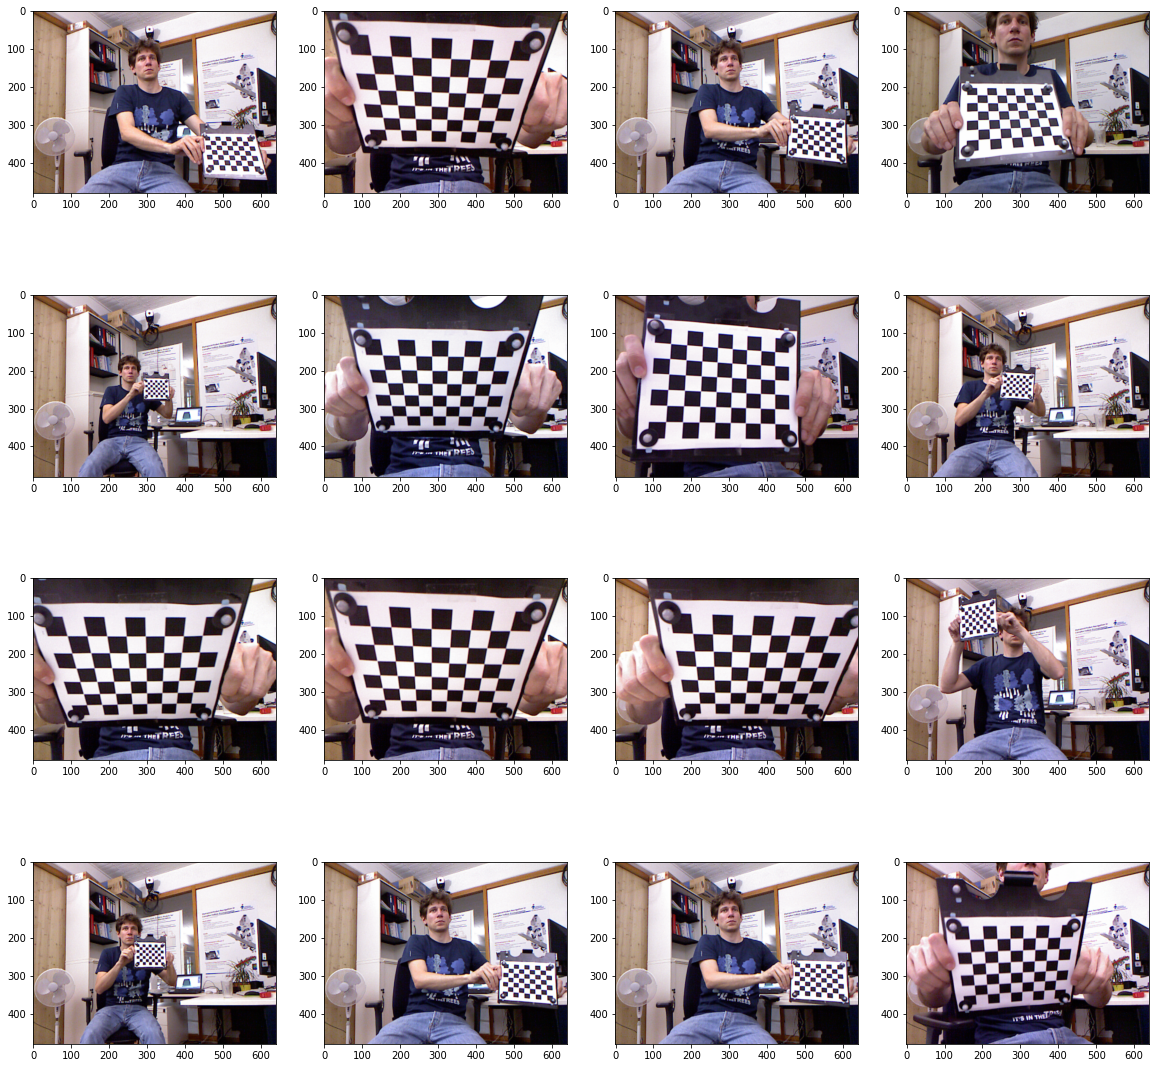

In [13]:
idx = np.random.randint(0,len(filepaths),250)
sub_filepaths = filepaths[idx]

fig, axs = plt.subplots(4, 4,figsize=(20,20))

for i, fp in zip(range(16),sub_filepaths):
    img = cv.imread(fp)
    axs[i//4,i%4].imshow(cv.cvtColor(img,cv.COLOR_BGR2RGB))

In [14]:
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.0001)

objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)
objpoints = list()
imgpoints = list()
for fp in tqdm(sub_filepaths):
    img = cv.imread(fp)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (7,6), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)
        # Draw and display the corners
        #cv.drawChessboardCorners(img, (7,6), corners2, ret)
        #cv.imshow('img', img)
        #cv.waitKey(500)

#cv.destroyAllWindows()

  0%|          | 0/250 [00:00<?, ?it/s]

* https://vision.in.tum.de/data/datasets/rgbd-dataset/file_formats#intrinsic_camera_calibration_of_the_kinect

In [15]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print("Camera instrisic matrix:\n",mtx)
print("Camea distortion coefficient\n",dist)

Camera instrisic matrix:
 [[526.6055557    0.         311.20166071]
 [  0.         526.66296011 254.19189933]
 [  0.           0.           1.        ]]
Camea distortion coefficient
 [[ 4.04520272e-01 -2.00098092e+00 -4.66063335e-03 -1.88872952e-03
   3.42733752e+00]]


In [16]:
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv.norm(imgpoints[i], imgpoints2, cv.NORM_L2)/len(imgpoints2)
    mean_error += error
print( "total error: {}".format(mean_error/len(objpoints)) )

total error: 0.3214324685432733


* The depth images are scaled by a factor of 5000, i.e., a pixel value of 5000 in the depth image corresponds to a distance of 1 meter from the camera, 10000 to 2 meter distance, etc. A pixel value of 0 means missing value/no data.

In [17]:
link = "https://vision.in.tum.de/rgbd/dataset/freiburg1/rgbd_dataset_freiburg1_teddy.tgz"
download_path = cwd+"/tmp/rgbd_dataset_freiburg1_teddy.tgz"

if os.path.isfile(download_path):
    print("File: "+download_path+" downloaded and extracted")
else:
    filename, headers = urlretrieve(link,download_path,show_progress)
    shutil.unpack_archive(download_path,cwd+"/tmp/")

teddy_rgb = glob(cwd+"/tmp/"+"rgbd_dataset_freiburg1_teddy/rgb/*.png")
teddy_rgb= sorted(teddy_rgb)
teddy_depth = glob(cwd+"/tmp/"+"rgbd_dataset_freiburg1_teddy/depth/*.png")
teddy_depth = sorted(teddy_depth)

File: /home/miro/Documents/PyCharmProjects/advanced-computer-vision/tmp/rgbd_dataset_freiburg1_teddy.tgz downloaded and extracted


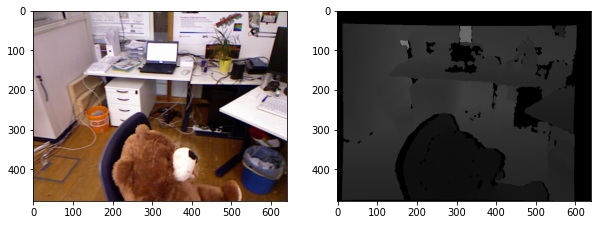

In [19]:
idx =250
img = cv.imread(teddy_rgb[idx])
depth_image = cv.imread(teddy_depth[idx])
plt.figure(figsize=(10,10))
plt.subplot(121)
img =  cv.cvtColor(img,cv.COLOR_BGR2RGB)
plt.imshow(img)
plt.subplot(122)
plt.imshow(depth_image)

In [20]:
factor=5000
fx = mtx[0,0]
fy = mtx[1,1]
cx = mtx[0,2]
cy = mtx[1,2]
X,Y,Z,R,G,B = list(),list(),list(),list(),list(),list()
for v in range(depth_image.shape[0]):
  for u in range(depth_image.shape[1]):
    z = depth_image[v,u,0] / factor
    Z.append(z)
    X.append((u - cx) * z / fx)
    Y.append((v - cy) * z / fy)
    R.append(img[v,u,0])
    G.append(img[v,u,1])
    B.append(img[v,u,2])

In [21]:
import open3d as o3d

cloud = o3d.geometry.PointCloud()
pts =np.array((X,Y,Z)).T
colors = np.array((R,G,B)).T/255
cloud.points = o3d.utility.Vector3dVector(pts)
cloud.colors = o3d.utility.Vector3dVector(colors)

o3d.visualization.draw_geometries([cloud])
